In [1]:
#import/install all packages at the top

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from pathlib import Path

In [2]:
#import our own functions from feature_stats.py script
#each imported individually for explicity

from features_stats import get_all_tokens
from features_stats import get_words
from features_stats import get_punct
from features_stats import average_word_length
from features_stats import average_sent_length
from features_stats import check_sarcsymbol
from features_stats import count_uppercase
from features_stats import get_lemmas
from features_stats import get_punct_average
from features_stats import get_sentiment
from features_stats import get_indiv_punct
from features_stats import relative_count_wordtypes
from features_stats import get_entities

In [3]:
#insert your own file directory path here
file_directory = Path("/Users/laure/OneDrive/Desktop/")

# Sections:

# (1) Import dataset and split
# (2) Functions
# (3) Irony Feature Extraction
- (3.1) Average Word Count
- (3.2) Average Sentence Count
- (3.3) Punctuation Richness
- (3.4) Sarcasm Symbol
- (3.5) Upper-case Words
- (3.6) Verb Lemmas
- (3.7) Sentiment Classification

- (3.8) Individual Punctuation Count
- (3.9) Word Type Count
- (3.10) Named Entity Count

# (4) No-irony Feature Extraction
- (4.1) Average Word Count
- (4.2) Average Sentence Count
- (4.3) Punctuation Richness
- (4.4) Sarcasm Symbol
- (4.5) Upper-case Words
- (4.6) Verb Lemma
- (4.7) Sentiment Classification

- (4.8) Individual Punctuation Count
- (4.9) Word Type Count
- (4.10) Named Entity Count

# (5) Get Final Summary Stats (ironic vs non-ironic)
------------ Create "Master" DataFrame Table, Save to CSV and Visualisation
- (5.1) Generl Summary
- (5.2) Individual Punctuation Count Summary
- (5.3) Word Type Count Summary
- (5.4) Named Entity Count Summary

#  (1) Import and Split

In [4]:
#import and read file in df with pandas (for better visualisation)

gold_label_filename =  file_directory / "irony-labeled.csv"

gold_label = pd.read_csv(gold_label_filename)

In [5]:
#rename the columns
gold_label.columns = ["Comment_Text", "Label"]

In [6]:
#checking for any missing values
missing_data = gold_label.isnull().sum()
missing_data

Comment_Text    0
Label           0
dtype: int64

In [7]:
#counts number of each class 
gold_label["Label"].value_counts()

#1 ironic
#-1 non-ironic

-1    1412
 1     537
Name: Label, dtype: int64

In [8]:
print("This dataset of Ironic and Non-ironic Reddit Comments entails", len(gold_label), "items")

This dataset of Ironic and Non-ironic Reddit Comments entails 1949 items


# Split into Train (70), Validation (10) and Test (20) sets

-using scikit learn 'train_test_split' function twices gives the validation set

In [9]:
#Split to get two DFs (prep for split)

y = gold_label["Comment_Text"]
x = gold_label["Label"]

In [10]:
#Split the dataset into TEST and TRAIN sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

#Split the TRAIN set again to get VALIDATION set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=43)

In [11]:
#JOIN the series together to get final splits as DFs
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
val = pd.concat([X_val, y_val], axis=1)

In [12]:
# pandas '.shape' to see dataframe in form of tuples (no. of rows / cols)

print("Training Data Shape:", train.shape)
print("Testing Data Shape:", test.shape)
print("Validation Data Shape:", val.shape)

Training Data Shape: (1364, 2)
Testing Data Shape: (390, 2)
Validation Data Shape: (195, 2)


# Summary of distribution of comments by labels 
# (Non-ironic = -1, Ironic = 1)

- use matplotlib to create THREE bar charts for visualisation for each of the sets:
        (1) Train
        (2) Validation
        (3) Test

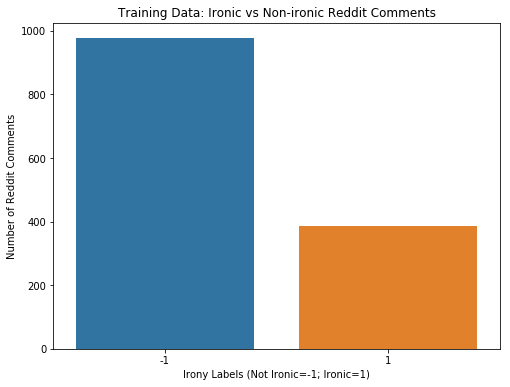

In [13]:
#TRAIN

fig = plt.figure(figsize=(8,6))
sns.barplot(x = train["Label"].unique(), 
            y=train["Label"].value_counts())

plt.title("Training Data: Ironic vs Non-ironic Reddit Comments")
plt.ylabel("Number of Reddit Comments")
plt.xlabel("Irony Labels (Not Ironic=-1; Ironic=1)")
plt.show()

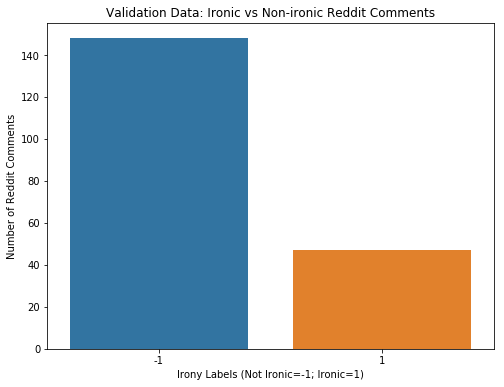

In [14]:
#VALIDATION

fig = plt.figure(figsize=(8,6))
sns.barplot(x = val["Label"].unique(), 
            y=val["Label"].value_counts())

plt.title("Validation Data: Ironic vs Non-ironic Reddit Comments")
plt.ylabel("Number of Reddit Comments")
plt.xlabel("Irony Labels (Not Ironic=-1; Ironic=1)")
plt.show()

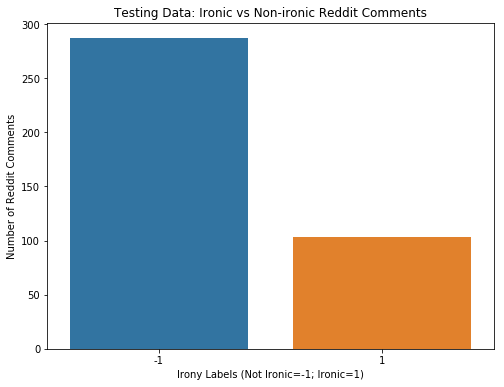

In [15]:
#TEST

fig = plt.figure(figsize=(8,6))
sns.barplot(x = test["Label"].unique(), 
            y=test["Label"].value_counts())

plt.title("Testing Data: Ironic vs Non-ironic Reddit Comments")
plt.ylabel("Number of Reddit Comments")
plt.xlabel("Irony Labels (Not Ironic=-1; Ironic=1)")
plt.show()

# TRAIN

In [16]:
#check format of train df
train.head()

train.replace("\n\n\n", "")

train.head()

,Label,Comment_Text
254,-1,Matthews must mistakenly think that if O'Reill...
331,1,Yep it is hard to get a good education and the...
1141,-1,/r/nottheonion
1642,-1,About. Fucking. Time.
1064,-1,The perimeters around this relaunching were ke...


In [17]:
#Split Train set into "Ironic" and "Non-ironic" DataFrames
ironic_train = train[train["Label"] == 1]
nonironic_train = train[train["Label"] == -1]

In [18]:
#Convert into two dictionaries
ironic_dict = ironic_train.set_index(ironic_train.index).T.to_dict()
nonironic_dict = nonironic_train.set_index(nonironic_train.index).T.to_dict()

print(f"Training data contains {len(ironic_dict)} IRONIC comments")
print(f"Training data contains {len(nonironic_dict)} NON- IRONIC comments")

Training data contains 387 IRONIC comments
Training data contains 977 NON- IRONIC comments


# (3)
# IRONY TRAINING

In [19]:
#1) GET ALL TOKENS
ir_tokens = get_all_tokens(ironic_dict)

In [20]:
#2) Get list of ONLY words (no punct)
ir_word_list = get_words(ir_tokens)

In [21]:
#3) Get list of ONLY punct (no words)
ir_punct_list = get_punct(ir_tokens)

In [22]:
#Create df for total, full returns for irony
total_ir_train= pd.DataFrame({'Ironic Comment Parsed':ir_tokens})
total_ir_train["Tokens"] = ir_word_list
total_ir_train["Punctuation"] = ir_punct_list
total_ir_train.head()

,Ironic Comment Parsed,Tokens,Punctuation
0,"(Yep, it, is, hard, to, get, a, good, educatio...","[Yep, it, is, hard, to, get, a, good, educatio...",[.]
1,"(So, the, question, during, their, Twitter, Q&...","[So, the, question, during, their, Twitter, Q&...","[..., .]"
2,"(They, hate, us, for, our, freedom, .)","[They, hate, us, for, our, freedom]",[.]
3,"(Did, he, talk, at, all, about, how, he, place...","[Did, he, talk, at, all, about, how, he, place...",[?]
4,"(&, gt, ;, "", Here, 's, a, picture, of, my, ho...","[&, gt, Here, 's, a, picture, of, my, house, \...","[;, "", "", ?, ?, ?]"


In [23]:
#4) AVERAGE WORD LENGTH
ir_average_word_leng = []
for comment in ir_word_list:
    ir_average_word_leng.append(average_word_length(comment))
    
#Create DataFrame for Summary of Irony STATS
summary_irony= pd.DataFrame({"Average Word Length": ir_average_word_leng})

In [24]:
#5) AVERAGE SENTENCE LENGTH
ir_average_sent_leng = []
for x in ir_tokens:
    ir_average_sent_leng.append(average_sent_length(x))

#Add to Summary of Irony STATS df
summary_irony["Average Sentence Length"] = ir_average_sent_leng
summary_irony.head()

,Average Word Length,Average Sentence Length
0,3.826087,24.0
1,4.636364,17.5
2,3.833333,7.0
3,4.444444,19.0
4,2.619048,9.0


In [25]:
#6) AVERAGE NUMBER OF SARCASM SYMBOL (/s)

ir_sarcfunc = []
for x in ir_tokens:
    ir_sarcfunc.append(check_sarcsymbol(x))

ir_sarcsymb_list = []        
for l in ir_sarcfunc:
    if len(l) >= 1:
        ir_sarcsymb_list.append(l)
    else:
        ir_sarcsymb_list.append([0])

#Remove list layer 
ir_sarcsymb_list = list(chain.from_iterable(ir_sarcsymb_list))

#Add result to Ironic Summary DF
summary_irony["Sarcasm Symbol (/s)"] = ir_sarcsymb_list

In [26]:
#7) AVERAGE NUMBER OF UPPER CASE WORDS (total)

ir_uppercase_list = []
for b in ir_tokens:
    ir_uppercase_list.append((count_uppercase(b)))
    
#Remove list layer 
ir_uppercase_list = list(chain.from_iterable(ir_uppercase_list))

#Add result to Ironic Summary DF
summary_irony["Uppercase Average"] = ir_uppercase_list
summary_irony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Uppercase Average
0,3.826087,24.0,0.0,0.0
1,4.636364,17.5,0.0,0.0
2,3.833333,7.0,0.0,0.0
3,4.444444,19.0,0.0,0.0
4,2.619048,9.0,0.0,0.0


In [27]:
#8) AVERAGE PUNCTUATION RICHNESS
ir_punct_avg = get_punct_average(ir_punct_list, ir_tokens)

#Add result to Ironic Summary DF
summary_irony["Punctuation Richness"] = ir_punct_avg
summary_irony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Uppercase Average,Punctuation Richness
0,3.826087,24.0,0.0,0.0,13.0
1,4.636364,17.5,0.0,0.0,19.5
2,3.833333,7.0,0.0,0.0,4.5
3,4.444444,19.0,0.0,0.0,10.5
4,2.619048,9.0,0.0,0.0,19.5


In [28]:
#9) AVERAGE NUMBER OF LEMMAS

ir_lemma_list = []
for doc in ir_tokens:
    ir_lemma_list.append(get_lemmas(doc))
    
len(ir_lemma_list)
    
summary_irony["Verb Lemma Average"] = ir_lemma_list
summary_irony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Uppercase Average,Punctuation Richness,Verb Lemma Average
0,3.826087,24.0,0.0,0.0,13.0,0.166667
1,4.636364,17.5,0.0,0.0,19.5,0.142857
2,3.833333,7.0,0.0,0.0,4.5,0.142857
3,4.444444,19.0,0.0,0.0,10.5,0.157895
4,2.619048,9.0,0.0,0.0,19.5,0.111111


In [29]:
#10 SENTIMENT CLASSIFICATION
#1 = positive, -1 = negative

ir_sentiment = get_sentiment(ironic_dict)

summary_irony["Sentiment Classification"] = ir_sentiment 

In [30]:
#replace NAN values
summary_irony = summary_irony.replace(np.nan, 0)
summary_irony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Uppercase Average,Punctuation Richness,Verb Lemma Average,Sentiment Classification
0,3.826087,24.0,0.0,0.0,13.0,0.166667,1
1,4.636364,17.5,0.0,0.0,19.5,0.142857,-1
2,3.833333,7.0,0.0,0.0,4.5,0.142857,1
3,4.444444,19.0,0.0,0.0,10.5,0.157895,1
4,2.619048,9.0,0.0,0.0,19.5,0.111111,-1


In [31]:
#11) AVERAGE FOR ALL PUNCTUATION MARKS (each individual)

ir_average_indivpunc_list = []
for x in ir_tokens:
    ir_average_indivpunc_list.append(get_indiv_punct(x))

#Create Summary DF for each individual Punctuation Mark
summary_irony_indivpunct = pd.DataFrame(ir_average_indivpunc_list)
summary_irony_indivpunct = summary_irony_indivpunct.replace(np.nan, 0)

In [32]:
#replace NAN values
summary_irony_indivpunct = summary_irony_indivpunct.replace(np.nan, 0)
summary_irony_indivpunct.head()

,!,"""",""")",%,&,',(,),*,",",...,?,[,\,],_,–,—,‘,“,”
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.074074,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,...,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
#12) AVERAGE FOR ALL WORD TYPES 

ir_average_wordtype_list = []
for comment in ir_tokens:
    ir_average_wordtype_list.append(relative_count_wordtypes(comment))

#Create Summary DF for Word Types
summary_irony_wordtype = pd.DataFrame(ir_average_wordtype_list)

ir_average_wordtype_list

[{'INTJ': 0.041666666666666664,
  'PRON': 0.08333333333333333,
  'VERB': 0.20833333333333334,
  'ADJ': 0.125,
  'PART': 0.041666666666666664,
  'DET': 0.125,
  'NOUN': 0.16666666666666666,
  'CCONJ': 0.041666666666666664,
  'ADV': 0.08333333333333333,
  'ADP': 0.041666666666666664,
  'PUNCT': 0.041666666666666664},
 {'ADV': 0.02857142857142857,
  'DET': 0.08571428571428572,
  'NOUN': 0.2857142857142857,
  'ADP': 0.17142857142857143,
  'ADJ': 0.08571428571428572,
  'PROPN': 0.02857142857142857,
  'VERB': 0.17142857142857143,
  'PART': 0.02857142857142857,
  'CCONJ': 0.02857142857142857,
  'PUNCT': 0.05714285714285714,
  'PRON': 0.02857142857142857},
 {'PRON': 0.2857142857142857,
  'VERB': 0.14285714285714285,
  'ADP': 0.14285714285714285,
  'ADJ': 0.14285714285714285,
  'NOUN': 0.14285714285714285,
  'PUNCT': 0.14285714285714285},
 {'VERB': 0.15789473684210525,
  'PRON': 0.10526315789473684,
  'ADV': 0.15789473684210525,
  'ADP': 0.15789473684210525,
  'ADJ': 0.15789473684210525,
  'NOU

In [34]:
#replace NAN values
summary_irony_wordtype = summary_irony_wordtype.replace(np.nan, 0)
summary_irony_wordtype.head()

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X
0,0.125000,0.041667,0.083333,0.041667,0.125000,0.041667,0.166667,0.0,0.041667,0.083333,0.000000,0.041667,0.000000,0.0,0.208333,0.0
1,0.085714,0.171429,0.028571,0.028571,0.085714,0.000000,0.285714,0.0,0.028571,0.028571,0.028571,0.057143,0.000000,0.0,0.171429,0.0
2,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.0,0.000000,0.285714,0.000000,0.142857,0.000000,0.0,0.142857,0.0
3,0.157895,0.157895,0.157895,0.000000,0.052632,0.000000,0.157895,0.0,0.000000,0.105263,0.000000,0.052632,0.000000,0.0,0.157895,0.0
4,0.037037,0.037037,0.148148,0.037037,0.074074,0.037037,0.148148,0.0,0.000000,0.037037,0.000000,0.222222,0.111111,0.0,0.111111,0.0


In [35]:
#13) AVERAGE FOR ALL NAMED ENTITIES 
ir_named_entity_list = []
for comment in ir_tokens:
    ir_named_entity_list.append(get_entities(comment))
    

#Create Summary DF for all Named Entities   
summary_irony_namedentity = pd.DataFrame(ir_named_entity_list)

In [36]:
#replace NAN values
summary_irony_namedentity = summary_irony_namedentity.replace(np.nan, 0)
summary_irony_namedentity.head()  

,CARDINAL,DATE,EVENT,FAC,GPE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


# (4)
# NO-IRONY 

In [37]:
#1) GET ALL TOKENS
nonir_tokens = get_all_tokens(nonironic_dict)

In [38]:
#2) Get list of ONLY words (no punct)
nonir_word_list = get_words(nonir_tokens)

In [39]:
#3) Get list of ONLY punct (no words)
nonir_punct_list = get_punct(nonir_tokens)

In [40]:
#Create df for total, full returns for irony
total_nonir_train= pd.DataFrame({'non-ironic Comment Parsed':nonir_tokens})
total_nonir_train["Tokens"] = nonir_word_list
total_nonir_train["Punctuation"] = nonir_punct_list
total_nonir_train.head()

,non-ironic Comment Parsed,Tokens,Punctuation
0,"(Matthews, must, mistakenly, think, that, if, ...","[Matthews, must, mistakenly, think, that, if, ...",[.]
1,"(/r, /, nottheonion)","[/, nottheonion]",[/r]
2,"(About, ., , Fucking, ., , Time, .)","[About, , Fucking, , Time]","[., ., .]"
3,"(The, perimeters, around, this, relaunching, w...","[The, perimeters, around, this, relaunching, w...",[.]
4,"(Typical, liberal)","[Typical, liberal]",[]


In [41]:
#4) AVERAGE WORD LENGTH
nonir_average_word_leng = []
for comment in nonir_word_list:
    nonir_average_word_leng.append(average_word_length(comment))
    
#Create DataFrame for Summary of Irony STATS
summary_noirony= pd.DataFrame({"Average Word Length": nonir_average_word_leng})

In [42]:
#5) AVERAGE SENTENCE LENGTH
nonir_average_sent_leng = []
for x in nonir_tokens:
    nonir_average_sent_leng.append(average_sent_length(x))

#Add to Summary of Irony STATS df
summary_noirony["Average Sentence Length"] = nonir_average_sent_leng
summary_noirony.head()

,Average Word Length,Average Sentence Length
0,4.750000,17.000000
1,6.000000,3.000000
2,3.600000,2.666667
3,5.285714,22.000000
4,7.000000,2.000000


In [43]:
#6) AVERAGE NUMBER OF SARCASM SYMBOL (/s)

nonir_sarcfunc = []
for x in nonir_tokens:
    nonir_sarcfunc.append(check_sarcsymbol(x))


nonir_sarcsymb_list = []        
for l in nonir_sarcfunc:
    if len(l) >= 1:
        nonir_sarcsymb_list.append(l)
    else:
        nonir_sarcsymb_list.append([0])

#Remove list layer 
nonir_sarcsymb_list = list(chain.from_iterable(nonir_sarcsymb_list))

#Add result to Ironic Summary DF
summary_noirony["Sarcasm Symbol (/s)"] = nonir_sarcsymb_list

In [44]:
#7) AVERAGE NUMBER OF UPPER CASE WORDS (total)

nonir_uppercase_list = []
for b in nonir_tokens:
    nonir_uppercase_list.append((count_uppercase(b)))
    
    
#Remove list layer 
nonir_uppercase_list = list(chain.from_iterable(nonir_uppercase_list))

#Add result to Ironic Summary DF
summary_noirony["Uppercase Average"] = nonir_uppercase_list
summary_noirony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Uppercase Average
0,4.750000,17.000000,0,0.0
1,6.000000,3.000000,0,0.0
2,3.600000,2.666667,0,0.0
3,5.285714,22.000000,0,0.0
4,7.000000,2.000000,0,0.0


In [45]:
#8) AVERAGE PUNCTUATION RICHNESS
nonir_punct_avg = get_punct_average(nonir_punct_list, nonir_tokens)

#Add result to Ironic Summary DF
summary_noirony["Punctuation Richness"] = nonir_punct_avg
summary_noirony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Uppercase Average,Punctuation Richness
0,4.750000,17.000000,0,0.0,9.5
1,6.000000,3.000000,0,0.0,2.5
2,3.600000,2.666667,0,0.0,7.0
3,5.285714,22.000000,0,0.0,12.0
4,7.000000,2.000000,0,0.0,1.0


In [46]:
#9) AVERAGE NUMBER OF LEMMAS

nonir_lemma_list = []
for doc in nonir_tokens:
    nonir_lemma_list.append(get_lemmas(doc))
    
summary_noirony["Verb Lemma Average"] = nonir_lemma_list
summary_noirony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Uppercase Average,Punctuation Richness,Verb Lemma Average
0,4.750000,17.000000,0,0.0,9.5,0.294118
1,6.000000,3.000000,0,0.0,2.5,0.000000
2,3.600000,2.666667,0,0.0,7.0,0.000000
3,5.285714,22.000000,0,0.0,12.0,0.227273
4,7.000000,2.000000,0,0.0,1.0,0.000000


In [47]:
#10 SENTIMENT CLASSIFICATION
#1 = positive, -1 = negative

nonir_sentiment = get_sentiment(nonironic_dict)

summary_noirony["Sentiment Classification"] = nonir_sentiment 

In [48]:
#replace NAN values

summary_noirony = summary_noirony.replace(np.nan)
summary_noirony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Uppercase Average,Punctuation Richness,Verb Lemma Average,Sentiment Classification
0,4.750000,17.000000,0,0.0,9.5,0.294118,1
1,6.000000,3.000000,0,0.0,2.5,0.000000,1
2,3.600000,2.666667,0,0.0,7.0,0.000000,-1
3,5.285714,22.000000,0,0.0,12.0,0.227273,-1
4,7.000000,2.000000,0,0.0,1.0,0.000000,1


In [49]:
#11) AVERAGE FOR ALL PUNCTUATION MARKS (each individual)

nonir_average_indivpunc_list = []
for x in nonir_tokens:
    nonir_average_indivpunc_list.append(get_indiv_punct(x))

#Create Summary DF for each individual Punctuation Mark
summary_noirony_indivpunct = pd.DataFrame(nonir_average_indivpunc_list)

In [50]:
#replace NAN values

summary_noirony_indivpunct = summary_noirony_indivpunct.replace(np.nan, 0)
summary_noirony_indivpunct.head()

,!,"""",#,%,&,',(,),*,",",...,?,[,],_,§,–,—,‘,“,”
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
#12) AVERAGE FOR ALL WORD TYPES 

nonir_average_wordtype_list = []
for comment in nonir_tokens:
    nonir_average_wordtype_list.append(relative_count_wordtypes(comment))

#Create Summary DF for Word Types
summary_noirony_wordtype = pd.DataFrame(nonir_average_wordtype_list)

In [52]:
#replace NAN values

summary_noirony_wordtype = summary_noirony_wordtype.replace(np.nan, 0)
summary_noirony_wordtype.head()

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X
0,0.000000,0.176471,0.058824,0.0,0.117647,0.0,0.117647,0.0,0.000000,0.058824,0.117647,0.058824,0.00,0.000000,0.294118,0.0
1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.000000,0.000000,0.333333,0.00,0.333333,0.000000,0.0
2,0.000000,0.125000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.250000,0.375000,0.25,0.000000,0.000000,0.0
3,0.090909,0.090909,0.045455,0.0,0.227273,0.0,0.181818,0.0,0.045455,0.000000,0.000000,0.045455,0.00,0.000000,0.272727,0.0
4,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0


In [53]:
#13) AVERAGE FOR ALL NAMED ENTITIES 
nonir_named_entity_list = []
for comment in nonir_tokens:
    nonir_named_entity_list.append(get_entities(comment))
    

#Create Summary DF for all Named Entities   
summary_noirony_namedentity = pd.DataFrame(nonir_named_entity_list)

In [54]:
summary_noirony_namedentity = summary_noirony_namedentity.replace(np.nan, 0)
summary_noirony_namedentity.head()  

,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.058824,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0


# (5)
# GET FINAL STATS FOR TRAINING 

- (1) General Summary: create shared DF (1, -1) with mean, save to CSV and show visual
- (2) Word Type summary: create shared DF (1, -1) with mean, save to CSV and show visual
- (3) Punctuation Mark summary: create shared DF (1, -1) with mean, save to CSV and show visual
- (4) Named Entity Recognition summary: create shared DF (1, -1) with mean, save to CSV and show visual

# (5.1) General Summary

In [55]:
#1) WORD LENGTH summary
ir_dist_word = summary_irony["Average Word Length"].mean()
non_ir_dist_word = summary_noirony["Average Word Length"].mean()

In [56]:
#2) SENTENCE LENGTH summary
ir_dist_sent = summary_irony["Average Sentence Length"].mean() 
non_ir_dist_sent = summary_noirony["Average Sentence Length"].mean()

In [57]:
#3) SARCASM SYMBOL (/s) summary
ir_sarcsymb = summary_irony["Sarcasm Symbol (/s)"].mean()
non_ir_sarcsymb = summary_noirony["Sarcasm Symbol (/s)"].mean()

In [58]:
#4) PUNCTUATION RICHNESS summary
ir_dist_punct = summary_irony["Punctuation Richness"].mean()
non_ir_dist_punct = summary_noirony["Punctuation Richness"].mean()

In [59]:
#5) UPPER-CASE LETTER summary
ir_uppercase = summary_irony["Uppercase Average"].mean()
non_ir_uppercase = summary_noirony["Uppercase Average"].mean()

In [60]:
#6) VERB LEMMA summary

ir_verblemma = summary_irony["Verb Lemma Average"].mean()
non_ir_verblemma = summary_noirony["Verb Lemma Average"].mean()

In [61]:
#7) SENTIMENT summary

ir_sentiment = summary_irony["Sentiment Classification"].mean()
nonir_sentiment = summary_noirony["Sentiment Classification"].mean()

In [62]:
#Create a Summary Stats df
# View both ironic/non-ironic average stats for each feature

summary_stats = pd.DataFrame(columns=["Average Word Length","Average Sentence Length"], index=["Ironic Comments", "Non-ironic Comments"])

summary_stats["Average Word Length"] = ir_dist_word, non_ir_dist_word
summary_stats["Average Sentence Length"] = ir_dist_sent, non_ir_dist_sent
summary_stats["Average '/s' symbol count"] = ir_sarcsymb, non_ir_sarcsymb
summary_stats["Average Upper-case Words"] = ir_uppercase, non_ir_uppercase
summary_stats["Punctuation Richness"] = ir_dist_punct, non_ir_dist_punct
summary_stats["Verb Lemma Average"] = ir_verblemma, non_ir_verblemma
summary_stats["Sentiment Classification"] = ir_sentiment, nonir_sentiment

summary_stats

,Average Word Length,Average Sentence Length,Average '/s' symbol count,Average Upper-case Words,Punctuation Richness,Verb Lemma Average,Sentiment Classification
Ironic Comments,4.304183,14.261968,0.000783,0.02535,20.927649,0.154378,0.405685
Non-ironic Comments,4.411010,15.805244,0.000000,0.02346,36.150972,0.146618,0.455476


In [63]:
#Save Master general table to CSV
summary_stats.to_csv(file_directory / "train_summary_general.csv")

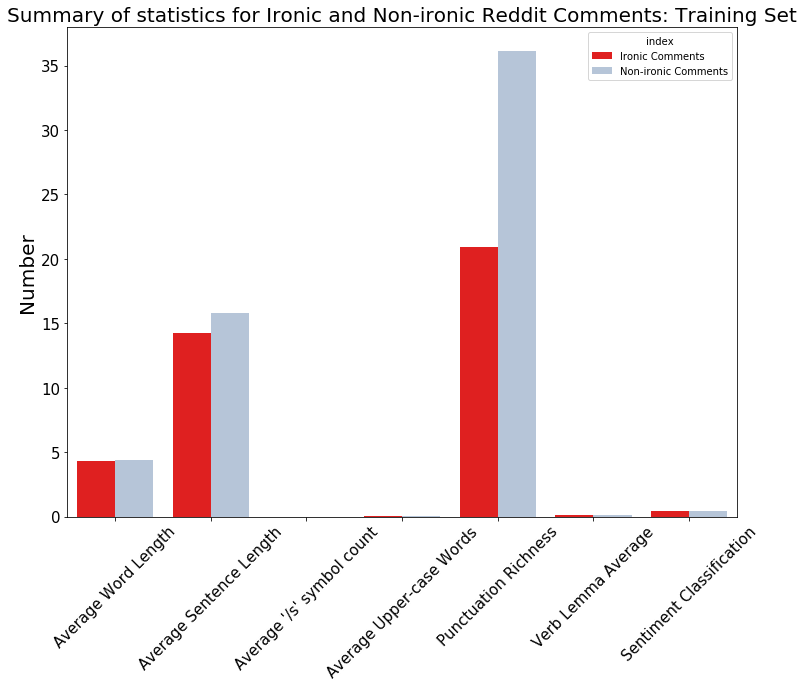

In [64]:
#Create Visualisation for Summary-stats DataFrame

reset_indexbar = summary_stats.reset_index().melt(id_vars=["index"]) 

plt.figure(figsize=(12,9)) #size on-screen
sns.barplot(x="variable", y="value", hue="index", data=reset_indexbar, palette=["red", "lightsteelblue"] )
plt.xticks(rotation=45)


plt.title("Summary of statistics for Ironic and Non-ironic Reddit Comments: Training Set", fontsize=20)
plt.ylabel("Number", fontsize=20)
plt.xlabel("")
plt.tick_params(labelsize=15)

#save grouped bar chart as png file
plt.savefig("train_summary_general.png")

# (5.2) POS Summary

In [65]:
#IRONIC word-type

ir_wordtype = summary_irony_wordtype.mean()
ir_wordtype = pd.DataFrame(ir_wordtype) 

#Clean df (switch columns, rename index, move index inwards to right (for grouped bar later))
ir_wordtype = ir_wordtype.T #transpose columns w. rows

In [66]:
#NON-IRONIC word-type

nonir_wordtype = summary_noirony_wordtype.mean()
non_ir_wordtype = pd.DataFrame(nonir_wordtype) 

#clean df (switch columns, rename index, move index inwards to right (for grouped bar later))
non_ir_wordtype = non_ir_wordtype.T #transpose columns w. rows

In [67]:
#WORD TYPE SUMMARY!
word_type_frames = [ir_wordtype, non_ir_wordtype]
summary_word_type = pd.concat(word_type_frames)
summary_word_type.index = "Ironic", "Non-ironic"

summary_word_type

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X
Ironic,0.085070,0.078270,0.064795,0.017629,0.073488,0.007642,0.164352,0.007932,0.022388,0.063109,0.058805,0.145819,0.031440,0.004067,0.174846,0.000348
Non-ironic,0.080089,0.083053,0.070846,0.023582,0.081000,0.005765,0.158435,0.009828,0.022023,0.061435,0.043878,0.141197,0.032398,0.005573,0.180089,0.000810


In [68]:
#Save Master pos table to CSV

summary_word_type.to_csv(file_directory / "train_summary_pos.csv")

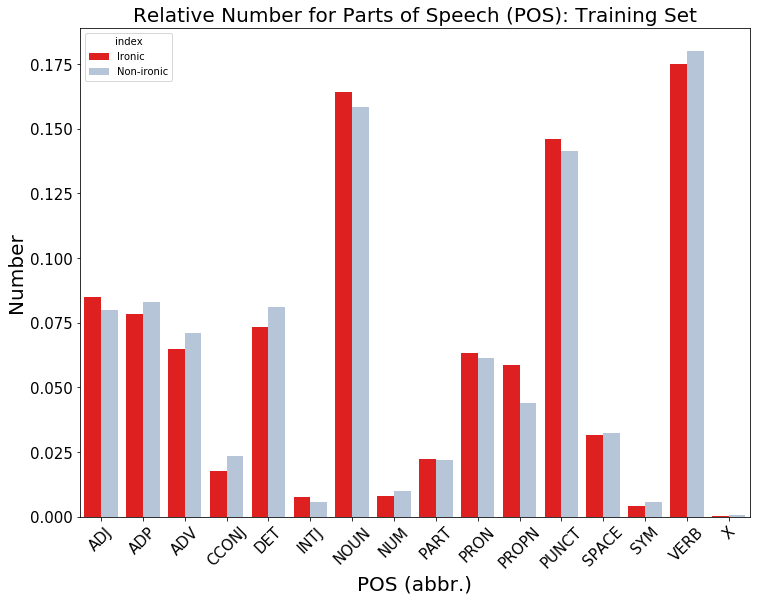

In [69]:
#WORD TYPE VISUAL SUMMARY

reset_indexbar_wordtypes = summary_word_type.reset_index().melt(id_vars=["index"]) 
#summary_stats.head()

plt.figure(figsize=(12,9)) #size on-screen
sns.barplot(x="variable", y="value", hue="index", data=reset_indexbar_wordtypes, palette=["red", "lightsteelblue"] )
plt.xticks(rotation=45)

# #instead of palette, try -- color = "lightsteelblue"

plt.title("Relative Number for Parts of Speech (POS): Training Set", fontsize=20)
plt.ylabel("Number", fontsize=20)
plt.xlabel("POS (abbr.)", fontsize=20)

#plt.xlabel("Statistics Type", fontsize=15)
plt.tick_params(labelsize=15)

#save grouped bar chart as png file
plt.savefig("train_summary_POS.png")

# (5.3) Punctuation Mark

In [70]:
#INDIVIDUAL PUNCT COUNT AVERAGE

#IRONIC
ir_punct_mean = summary_irony_indivpunct.mean()
ir_punct = pd.DataFrame(ir_punct_mean)
summary_ir_punct = ir_punct.T
summary_ir_punct.index.names = ["Ironic"]

In [71]:
#NON-IRONIC
nonir_punct_mean = summary_noirony_indivpunct.mean()
nonir_punct = pd.DataFrame(nonir_punct_mean)
summary_nonir_punct = nonir_punct.T
summary_nonir_punct.index.names = ["Non-ironic"]

In [72]:
indiv_punct_frames = [summary_ir_punct, summary_nonir_punct]
summary_punct_count = pd.concat(indiv_punct_frames, sort=True)
summary_punct_count.index = "Ironic", "Non-ironic"

In [73]:
#replace NaN with 0 for easier understanding
summary_punct_count = summary_punct_count.replace(np.nan, 0)

In [74]:
#Save Master punctuation table to CSV
summary_punct_count.to_csv(file_directory / "train_summary_puncttype.csv")

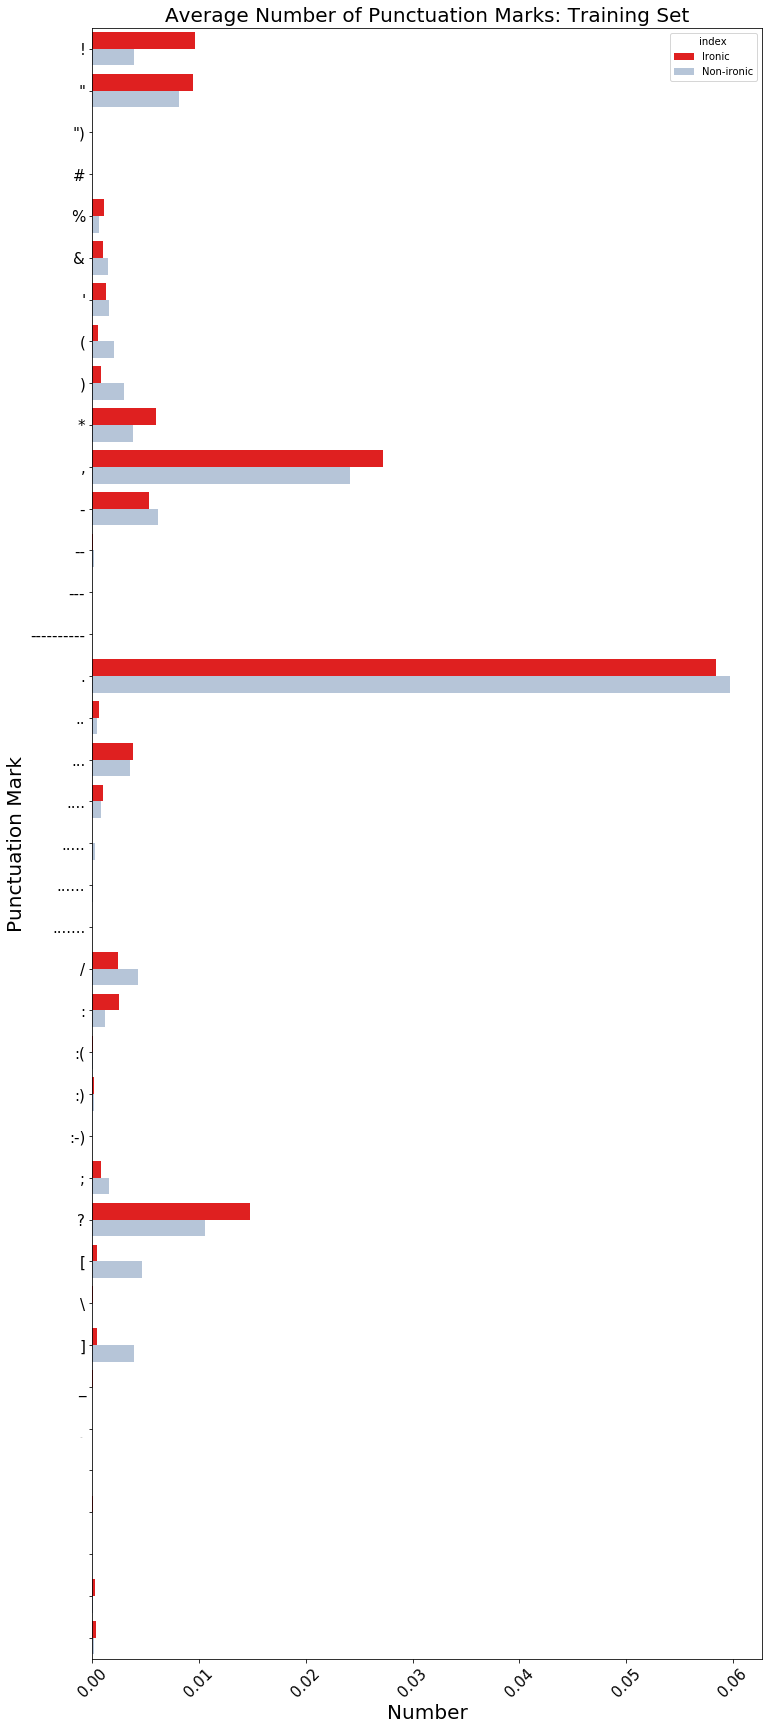

In [75]:
#INDIVIDUAL PUCNTUATION VISUAL SUMMARY

reset_indexbar_indpunct = summary_punct_count.reset_index().melt(id_vars=["index"]) 
#summary_punct_count.head()

plt.figure(figsize=(12,30)) #size on-screen
sns.barplot(x="value", y="variable", hue="index", data=reset_indexbar_indpunct, palette=["red", "lightsteelblue"] )
plt.xticks(rotation=45)

# #instead of palette, try -- color = "lightsteelblue"

plt.title("Average Number of Punctuation Marks: Training Set", fontsize=20)
plt.ylabel("Punctuation Mark", fontsize=20)
plt.xlabel("Number", fontsize=20)

#plt.xlabel("Statistics Type", fontsize=15)
plt.tick_params(labelsize=15)

#save grouped bar chart as png file
plt.savefig("train_summary_punctuation.png")

# (5.4) NAMED-ENTITIES

In [76]:
#IRONIC

ir_entity = summary_irony_namedentity.mean()
ir_entity = pd.DataFrame(ir_entity) 

#clean df (switch columns, rename index, move index inwards to right (for grouped bar later))
ir_entity = ir_entity.T #transpose columns w. rows

In [77]:
#NON-IRONIC

non_ir_entity = summary_noirony_namedentity.mean()
non_ir_entity = pd.DataFrame(non_ir_entity)

# #clean df (switch columns, rename index, move index inwards to right (for grouped bar later))
non_ir_entity = non_ir_entity.T #transpose columns w. rows

In [78]:
#NAMED ENTITIES grouped summary df

entity_frames = [ir_entity, non_ir_entity]
summary_entity = pd.concat(entity_frames, sort=True)
summary_entity.index = "Ironic", "Non-ironic"
summary_entity.replace(np.nan, 0)

,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
Ironic,0.004144,0.003744,0.000066,0.000008,0.006832,0.000000,0.000155,0.000820,0.001215,0.008090,0.000965,0.013508,0.001186,0.010383,0.000144,0.000008,0.000418,0.000280
Non-ironic,0.004955,0.004464,0.000106,0.000078,0.004595,0.000044,0.000126,0.000499,0.000849,0.006177,0.000913,0.008829,0.000773,0.009020,0.000049,0.000225,0.000444,0.000677


In [79]:
#Save Master general table to CSV

summary_entity.to_csv(file_directory / "train_summary_namedentity.csv")

In [80]:
#NER VISUAL SUMMARY

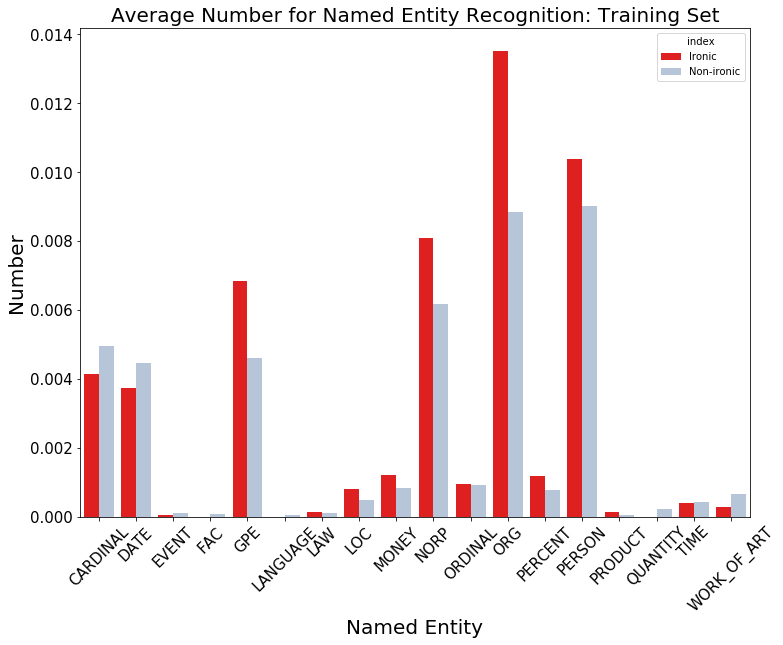

In [81]:
#NAMED ENTITY SUMMARY VISUAL 

reset_indexbar_entity = summary_entity.reset_index().melt(id_vars=["index"]) 

plt.figure(figsize=(12,9)) #size on-screen
sns.barplot(x="variable", y="value", hue="index", data=reset_indexbar_entity, palette=["red", "lightsteelblue"] )
plt.xticks(rotation=45)

plt.title("Average Number for Named Entity Recognition: Training Set", fontsize=20)
plt.ylabel("Number", fontsize=20)
plt.xlabel("Named Entity", fontsize=20)

plt.tick_params(labelsize=15)
#save grouped bar chart as png file
plt.savefig("train_summary_NER.png")

In [82]:
#extra
#check for named entitiy labelling through spacy for IRONIC comments
#may have to scroll to very end as some comments with apparent no named entities
ir_ent_visual = spacy.displacy.render(ir_tokens, style="ent", jupyter=True)

NameError: name 'spacy' is not defined

In [ ]:
#extra
#check for named entitiy labelling through spacy for NON-IRONIC
#may have to scroll to very end as some comments with apparent no named entities
nonir_ent_visual = spacy.displacy.render(nonir_tokens, style="ent", jupyter=True)